![](immagine.jpg)

# Mercato delle Guest House su Booking


Questo report prende in analisi alcune Guest House del territorio italiano presenti su Booking, focalizzandosi su aspetti rilevanti per imprenditori e investitori nel settore degli affitti brevi. L’obiettivo è fornire una panoramica dettagliata utile a chi desidera comprendere le dinamiche del mercato e individuare le opportunità di investimento più interessanti.  

Per scaricare i Databases clicca qui:  
-> [Database guest house](https://www.kaggle.com/datasets/aakashshinde1507/villas-in-italy)  
-> [Database regioni](http://www.istat.it/storage/codici-unita-amministrative/Elenco-codici-statistici-e-denominazioni-delle-unit%C3%A0-territoriali.zip) (questo database è stato lavorato prima di essere importato)  
-> [Database prezzi delle case in Italia](https://www.kaggle.com/datasets/tommasoramella/italy-house-prices?select=sale_raw.csv) (il database in particolare si chiama <u>sale_raw.csv</u> ed è stato lavorato prima di essere importato)


**INDICE:**  
1. Database guest house 
2. Database regioni   
3. Costruzione del dataset  
4. Prezzo vs Valutazione: Il Rapporto Qualità-Prezzo degli Alloggi
5. Analisi dei Prezzi Medi e della Competizione nelle Diverse Regioni  
6. Dove si Trovano gli Alloggi Meglio Valutati: Analisi delle Valutazioni Medie per Regione  
8. Database Prezzo delle Case in Italia  
9. ROI 
7. Conclusioni
___

In [1]:
import polars as pl
import pandas as pd
from unidecode import unidecode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
df_case = pd.read_csv(r"Guest Houses in Italy.csv")
df_regioni=pd.read_excel(r"Elenco-comuni-italiani.xlsx")

## 1. Database guest house 

___ 
In questa fase iniziale, mi occupo della preparazione del database "guest house" per le analisi successive. Per prima cosa, verifico il numero di colonne e righe presenti nel dataset. Successivamente, visualizzo i nomi delle colonne e procedo con la loro ridenominazione per renderle più intuitive e facili da utilizzare.

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000) 

In [4]:
df_case.shape

(30070, 10)

In [5]:
print(f"INDICE COLONNE: \n{df_case.columns}")

INDICE COLONNE: 
Index(['Unnamed: 0', 'Guest House', 'Place', 'room', 'bed', 'Condition', 'price', 'Travel Sustainable Level', 'Rating', 'Total Reviews'], dtype='object')


In [6]:
df_case.rename(columns= {'Unnamed: 0' : 'ID',
                         'Place' : 'luogo',
                         'room' : 'stanza',
                         'bed' : 'letto',
                         'price' : 'prezzo_in_$',
                         'Rating' : 'valutazione',
                         'Total Reviews' : 'n_recensioni'}, inplace=True)

Controllo la presenza dei valori nulli ed elimino le colonne che non servono all'analisi

In [7]:
valiori_null = df_case.isnull().sum()
print(f"COLONNE CON VALORI NULLI: \n{valiori_null[valiori_null > 0]}")

COLONNE CON VALORI NULLI: 
letto                           2
Condition                     116
prezzo_in_$                    49
Travel Sustainable Level    25295
valutazione                   116
n_recensioni                  116
dtype: int64


In [8]:
df_case.drop(columns=['Travel Sustainable Level', 'Condition'],inplace=True)

Preparo i valori alle analisi sucessive, isolo la parte numerica ed cambiando il type in float

In [9]:
df_case = df_case[df_case['prezzo_in_$'].notnull() & df_case['valutazione'].notnull()]

In [10]:
df_case['prezzo_in_$'] = df_case['prezzo_in_$'].str.replace('US$', '') 
df_case['prezzo_in_$'] = df_case['prezzo_in_$'].str.replace(',', '')
df_case['prezzo_in_$'] = df_case['prezzo_in_$'].str.replace(' ', '')
df_case['prezzo_in_$'] = pd.to_numeric(df_case['prezzo_in_$'])

In [11]:
df_case['n_recensioni'] = df_case['n_recensioni'].str.replace('reviews', '')
df_case['n_recensioni'] = df_case['n_recensioni'].str.replace('review', '')
df_case['n_recensioni'] = df_case['n_recensioni'].str.replace(',', '')
df_case['n_recensioni'] = df_case['n_recensioni'].str.replace(' ', '')
df_case['n_recensioni'] = pd.to_numeric(df_case['n_recensioni'])

## 2. Database regioni  

___
Ora lavoro il database "regioni" per rendermi conto com'è composto e poterlo sfruttare al meglio integradolo al database guest house

In [12]:
df_regioni.shape

(7896, 4)

In [13]:
print(f"INDICE COLONNE: \n{df_regioni.columns}")

INDICE COLONNE: 
Index(['Denominazione in italiano', 'Ripartizione geografica', 'Denominazione Regione', 'Denominazione dell'Unità territoriale sovracomunale \n(valida a fini statistici)'], dtype='object')


Rinomino le variabili con nomi più accessibili

In [14]:
df_regioni.rename(columns= {'Denominazione in italiano' : 'luogo',
                            'Ripartizione geografica' : 'posizione',
                            'Denominazione Regione' : 'regione',
                            "Denominazione dell'Unità territoriale sovracomunale \n(valida a fini statistici)" : 'provincia'}, inplace=True)

Controllo la presenza dei valori nulli

In [15]:
valiori_nulli = df_regioni.isnull().sum()
print(f"COLONNE CON VALORI NULLI: \n{valiori_nulli[valiori_nulli > 0]}")

COLONNE CON VALORI NULLI: 
luogo    1
dtype: int64


## 3. Costruzione del dataset  

___

Pulisco il dato, eliminando la parte di testo superflua ed isolando il nome della città, poi traduco le città che sono in inglese ed elimino gli accenti, converto i trattini in spazi e formatto tutte i valori in modo che inizino con la lettera maiuscola, in modo da avere una maggiore compatibilità tra i due database

In [16]:
df_case['luogo'] = df_case['luogo'].apply(lambda città: città.split(',')[1].strip() if ',' in città else città)

In [17]:
df_case['luogo'] = df_case['luogo'].replace({'Rome': 'Roma',
                                             'Turin': 'Torino',
                                             'Naples': 'Napoli',
                                             'Venice': 'Venezia',
                                             'Florence': 'Firenze',
                                             'Genoa' : 'Genova',
                                             'Padua' : 'Padova',
                                             'Vols am Schlern': 'Fiè allo Sciliar'})


In [18]:
df_case['luogo'] = df_case['luogo'].apply(str.capitalize)
df_case['luogo'] = df_case['luogo'].apply(unidecode)
df_case['luogo'] = df_case['luogo'].str.replace('-', ' ')

In [19]:
df_regioni = df_regioni[df_regioni['luogo'].notnull()]
df_regioni['luogo'] = df_regioni['luogo'].apply(str.capitalize)
df_regioni['luogo'] = df_regioni['luogo'].apply(unidecode)
df_regioni['luogo'] = df_regioni['luogo'].replace('-', ' ')

In [20]:
merged = pd.merge(df_case, df_regioni, on='luogo', how='inner')

Ora lavoro sul nuovo databaset per rendermi conto com'è composto e se ci sono valori nulli 

In [21]:
merged.shape

(26904, 11)

In [22]:
print(f"INDICE COLONNE: \n{merged.columns}")

INDICE COLONNE: 
Index(['ID', 'Guest House', 'luogo', 'stanza', 'letto', 'prezzo_in_$', 'valutazione', 'n_recensioni', 'posizione', 'regione', 'provincia'], dtype='object')


In [23]:
valiori_nulli = merged.isnull().sum()
print(f"COLONNE CON VALORI NULLI: \n{valiori_nulli[valiori_nulli > 0]}")

COLONNE CON VALORI NULLI: 
Series([], dtype: int64)


## 4. Prezzo vs Valutazione: Il Rapporto Qualità-Prezzo degli Alloggi  

___
In questa analisi, la qualità di un allogio la misuro con la sua valutazione, che rappresenta la media dei voti ricevuti dai clienti su Booking

Calcolo la media delle valutazione e del prezzo per ogni città

In [24]:
media_valutazione_città = merged.groupby('luogo').apply(lambda x: (x['valutazione'] * x['n_recensioni']).sum() / x['n_recensioni'].sum())
media_prezzo_città = merged.groupby('luogo')['prezzo_in_$'].mean()

C:\Users\albis\AppData\Local\Temp\ipykernel_3224\1758174998.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  media_valutazione_città = merged.groupby('luogo').apply(lambda x: (x['valutazione'] * x['n_recensioni']).sum() / x['n_recensioni'].sum())


Costruisco un database con le metrice precedentemente calcolate

In [25]:
media_valutazione_città = media_valutazione_città.reset_index(name='media_valutazione')
media_prezzo_città = media_prezzo_città.reset_index(name='media_prezzo')

qualità_prezzo_città = pd.merge(media_valutazione_città, media_prezzo_città, on = "luogo", how="inner")

Calcolo il rapporto qualità-prezzo

In [26]:
def calcola_qualita_prezzo(row):
    return row['media_valutazione'] / row['media_prezzo']

qualità_prezzo_città['rapporto_qualità_prezzo'] = qualità_prezzo_città.apply(calcola_qualita_prezzo, axis=1)

città_ordinate = qualità_prezzo_città.sort_values(by='rapporto_qualità_prezzo', ascending=False).reset_index()

#### 4.1 Le 5 migliori città per rapporto qualità-prezzo

In [27]:
top_5_città = città_ordinate.head(5)

tabella_pivot_migliori = top_5_città.pivot_table(index='luogo',
                                                  values=['media_valutazione', 'media_prezzo','rapporto_qualità_prezzo']).sort_values(by='rapporto_qualità_prezzo', 
                                                                                                                                      ascending=False).reset_index()

tabella_pivot_migliori

,luogo,media_prezzo,media_valutazione,rapporto_qualità_prezzo
0,Mazara del vallo,28.000000,8.639501,0.308554
1,Elini,32.000000,9.500000,0.296875
2,Samugheo,30.000000,8.800000,0.293333
3,Peschici,31.727273,8.600000,0.271060
4,Lipari,31.666667,8.400000,0.265263


Da questa tabella si evincono che le città con il miglior rapporto qualità-prezzo su Booking.  
Queste località rappresentano un'opportunità eccellente, in quanto possiamo offrire sistemazioni a costi competitivi senza compromettere la qualità dei servizi. Le recensioni positive e la crescente domanda di queste destinazioni suggeriscono che i viaggiatori sono sempre più attratti da esperienze di soggiorno vantaggiose. Investire in queste aree ci consente di attrarre una clientela sensibile al prezzo, garantendo un'ottima occupazione e una solida reputazione nel mercato.

#### 4.2 Le 5 peggiori città per rapporto qualità-prezzo

In [28]:
peggiori_5_città = città_ordinate.tail(5)

tabella_pivot_peggiori = peggiori_5_città.pivot_table(index='luogo',
                                         values=['media_valutazione', 'media_prezzo', 'rapporto_qualità_prezzo']).sort_values(by='rapporto_qualità_prezzo').reset_index()

tabella_pivot_peggiori

,luogo,media_prezzo,media_valutazione,rapporto_qualità_prezzo
0,Tropea,480.222222,8.907847,0.018549
1,Mantova,219.300847,8.792729,0.040094
2,Riomaggiore,186.696262,8.328751,0.044611
3,Procida,203.000000,9.300000,0.045813
4,Varenna,198.000000,9.200000,0.046465


Da questa tabella si evincono le città con il peggior rapporto qualità-prezzo su Booking.  
Le quali hanno costi i degli alloggi significativamente elevati rispetto ai servizi forniti, creando una sfida per gli operatori del settore. Sebbene queste città siano rinomate per la loro bellezza e il loro fascino, è fondamentale monitorare attentamente il mercato per garantire che le offerte rimangano competitive e soddisfino le aspettative dei clienti. L'alta pressione sui prezzi potrebbe rendere più difficile attirare ospiti, quindi è essenziale considerare strategie di marketing innovative e potenziali miglioramenti ai servizi per incrementare la soddisfazione del cliente.

### 4.3  Rapproto qualità-prezzo per regione

Calcolo la media delle valutazione e del prezzo per ogni regione

In [29]:
media_valutazione_regione = merged.groupby('regione').apply(lambda x: (x['valutazione'] * x['n_recensioni']).sum() / x['n_recensioni'].sum())
media_prezzo_regione = merged.groupby('regione')['prezzo_in_$'].mean()

C:\Users\albis\AppData\Local\Temp\ipykernel_3224\2475699437.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  media_valutazione_regione = merged.groupby('regione').apply(lambda x: (x['valutazione'] * x['n_recensioni']).sum() / x['n_recensioni'].sum())


Costruisco un database con le metrice precedentemente calcolate

In [30]:
media_valutazione_regione = media_valutazione_regione.reset_index(name='media_valutazione')
media_prezzo_regione = media_prezzo_regione.reset_index(name='media_prezzo')

qualità_prezzo_regione = pd.merge(media_valutazione_regione, media_prezzo_regione, on = "regione", how="inner")

Calcolo il rapporto qualità-prezzo

In [31]:
qualità_prezzo_regione['rapporto_qualità_prezzo'] = qualità_prezzo_regione.apply(calcola_qualita_prezzo, axis=1)

In [32]:
tabella_pivot_regione = qualità_prezzo_regione.pivot_table(index='regione',
                                                  values=['media_valutazione', 'media_prezzo','rapporto_qualità_prezzo'])

C:\Users\albis\AppData\Local\Temp\ipykernel_3224\953679775.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data= tabella_pivot_regione, x='regione', y='rapporto_qualità_prezzo', palette='viridis')


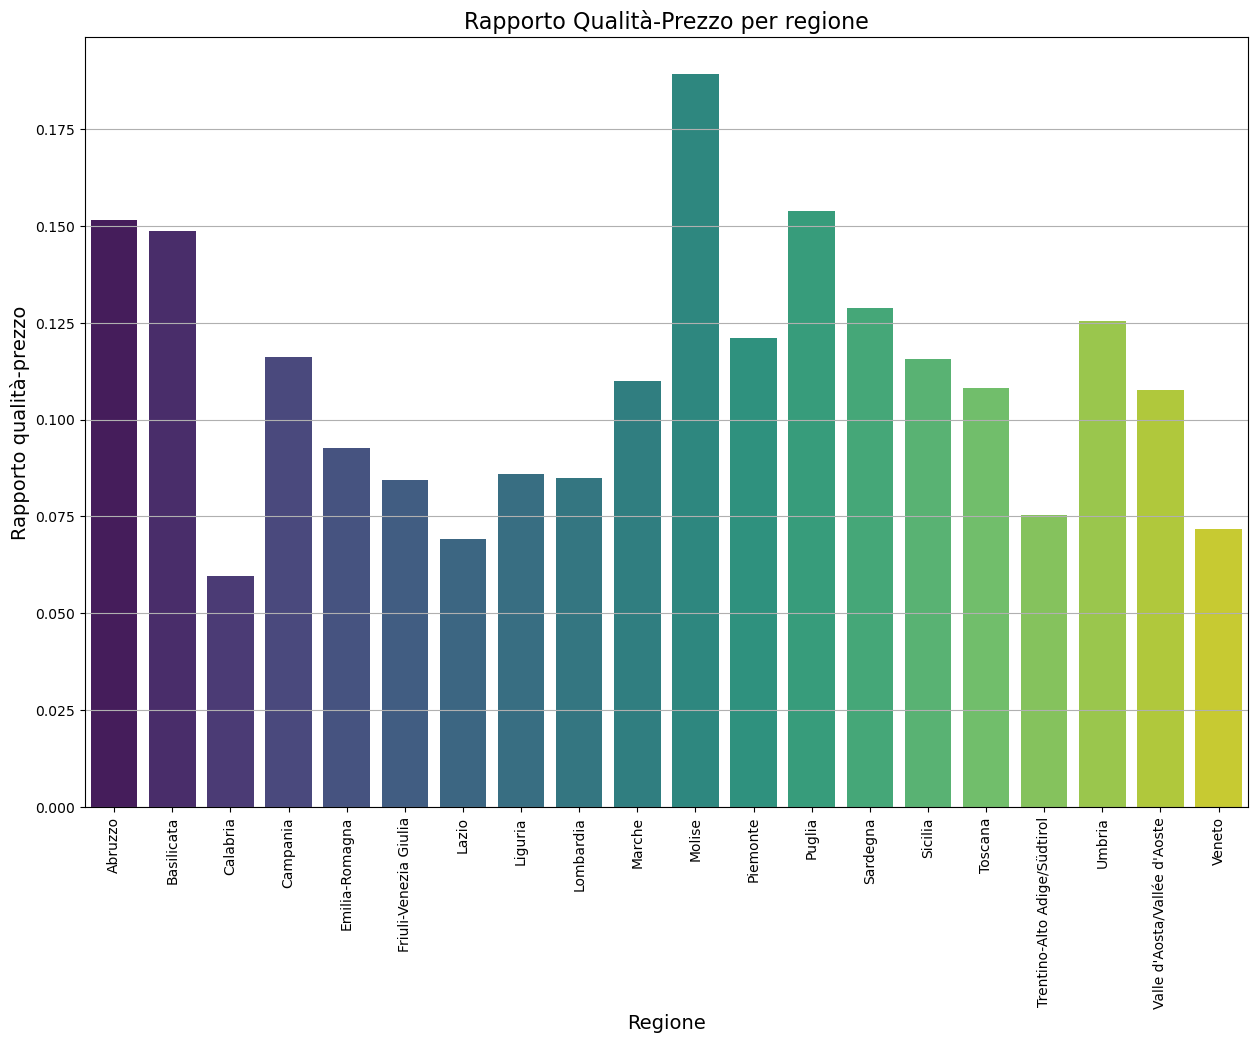

In [33]:
plt.figure(figsize=(15, 10))
sns.barplot(data= tabella_pivot_regione, x='regione', y='rapporto_qualità_prezzo', palette='viridis')
plt.title('Rapporto Qualità-Prezzo per regione', fontsize=16)
plt.ylabel('Rapporto qualità-prezzo', fontsize=14)
plt.xlabel('Regione', fontsize=14)
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.show()

Dalla nostra analisi, le regioni con il miglior rapporto qualità-prezzo su Booking sono:

1. Molise
2. Puglia
3. Abruzzo

Queste regioni offrono un’ottima opportunità per gli investitori, poiché possiamo posizionare le nostre strutture a prezzi accessibili, assicurando al contempo un'elevata qualità dei servizi. La crescente domanda di turisti in cerca di esperienze autentiche e convenienti ci permette di attrarre un’ampia clientela, ottimizzando i tassi di occupazione e rafforzando la nostra presenza nel mercato.

D'altro canto, le regioni con il peggior rapporto qualità-prezzo su Booking sono:

1. Calabria
2. Lazio
3. veneto

In queste aree, i costi degli alloggi tendono ad essere molto alti rispetto ai servizi offerti. Questo scenario presenta delle sfide significative per gli operatori. Anche se queste regioni godono di una grande notorietà e di una forte attrattiva turistica, è cruciale adottare strategie di differenziazione per mantenere il valore competitivo.

## 5. Analisi dei Prezzi Medi e della Competizione nelle Diverse Regioni

___

Di seguito la rappresentazione grafica della media di prezzo per ogni regione, in questo modo possiamo vedere in quali di essi il prezzo risulta più elevato o più basso rispetto alle altre, permettendoci di identificare eventuali trend o disparità geografiche. Questo confronto visivo aiuta a individuare le aree in cui i prezzi sono più competitivi o, al contrario, dove potrebbero essere considerati troppo elevati rispetto alla media complessiva.

In [34]:
media_prezzo_regione = merged.groupby('regione')['prezzo_in_$'].mean().reset_index(name='prezzo_medio')

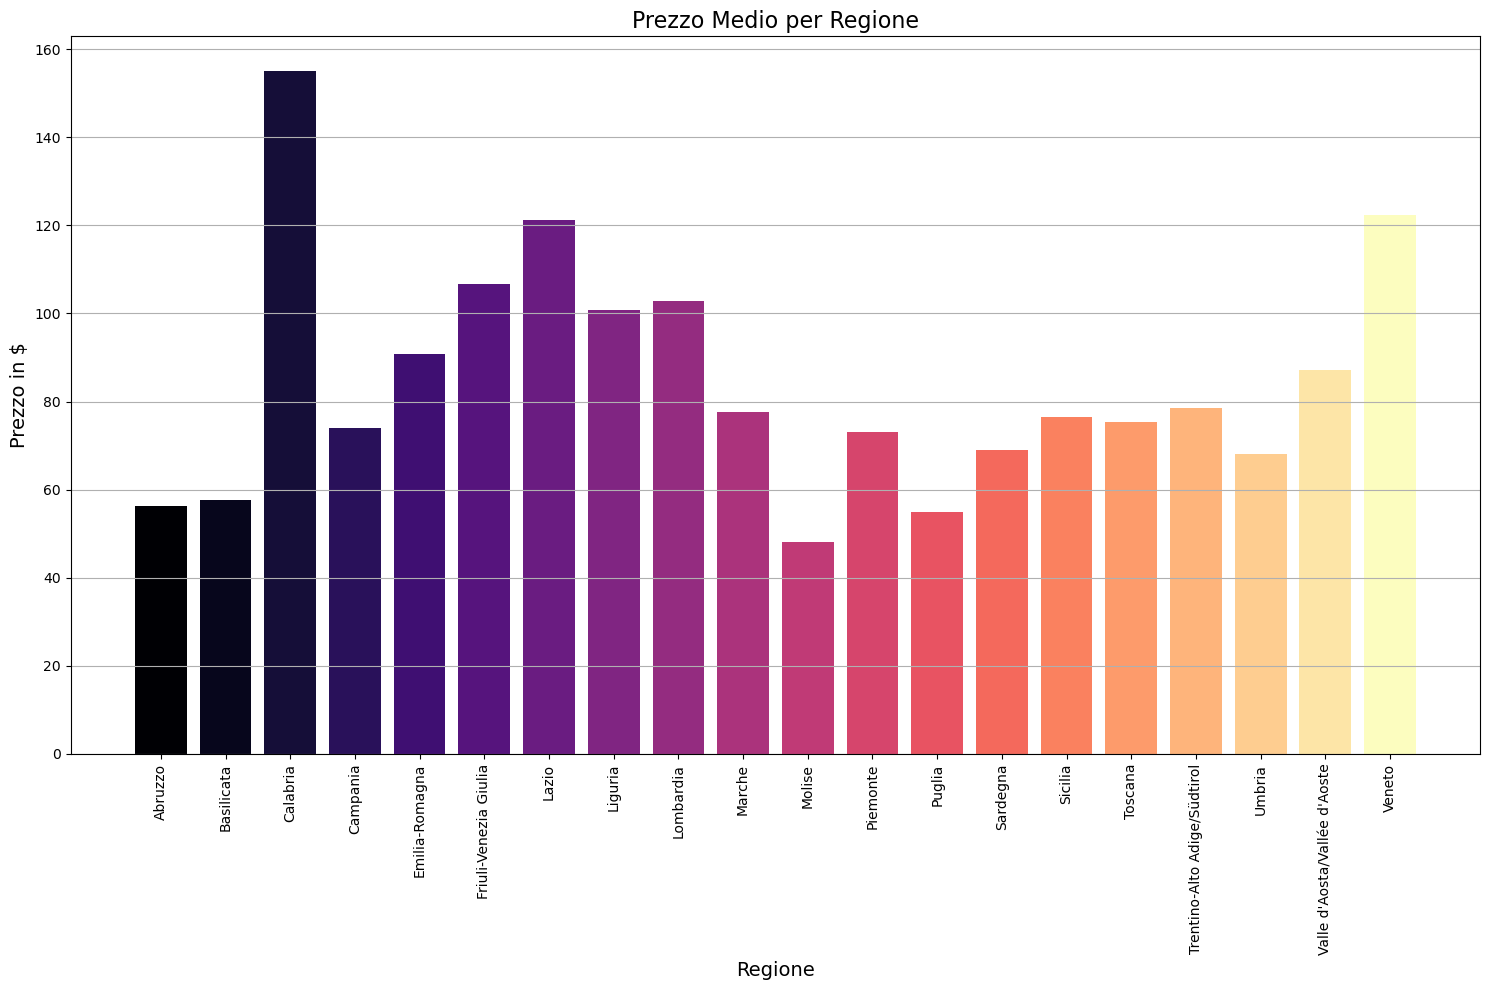

In [35]:
plt.figure(figsize=(15, 10))
colors = cm.magma(np.linspace(0, 1, len(media_prezzo_regione)))
plt.bar( media_prezzo_regione['regione'], media_prezzo_regione['prezzo_medio'], color=colors)
plt.xlabel('Regione', fontsize=14)
plt.ylabel('Prezzo in $', fontsize=14)
plt.title('Prezzo Medio per Regione', fontsize=16)
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.tight_layout()

Nel prossimo grafico vedremo il numero di alloggi presenti per regione, che nella nostra analisi rappresenteranno i nostri competitor, permettendoci di valutare la densità del mercato in ciascuna area geografica. Questo ci aiuterà a comprendere meglio il livello di concorrenza locale e a identificare le regioni dove l'offerta è più o meno saturata, fornendo indicazioni utili per orientare le strategie di posizionamento e pricing.

C:\Users\albis\AppData\Local\Temp\ipykernel_3224\445459658.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = merged, x="regione", palette='plasma')


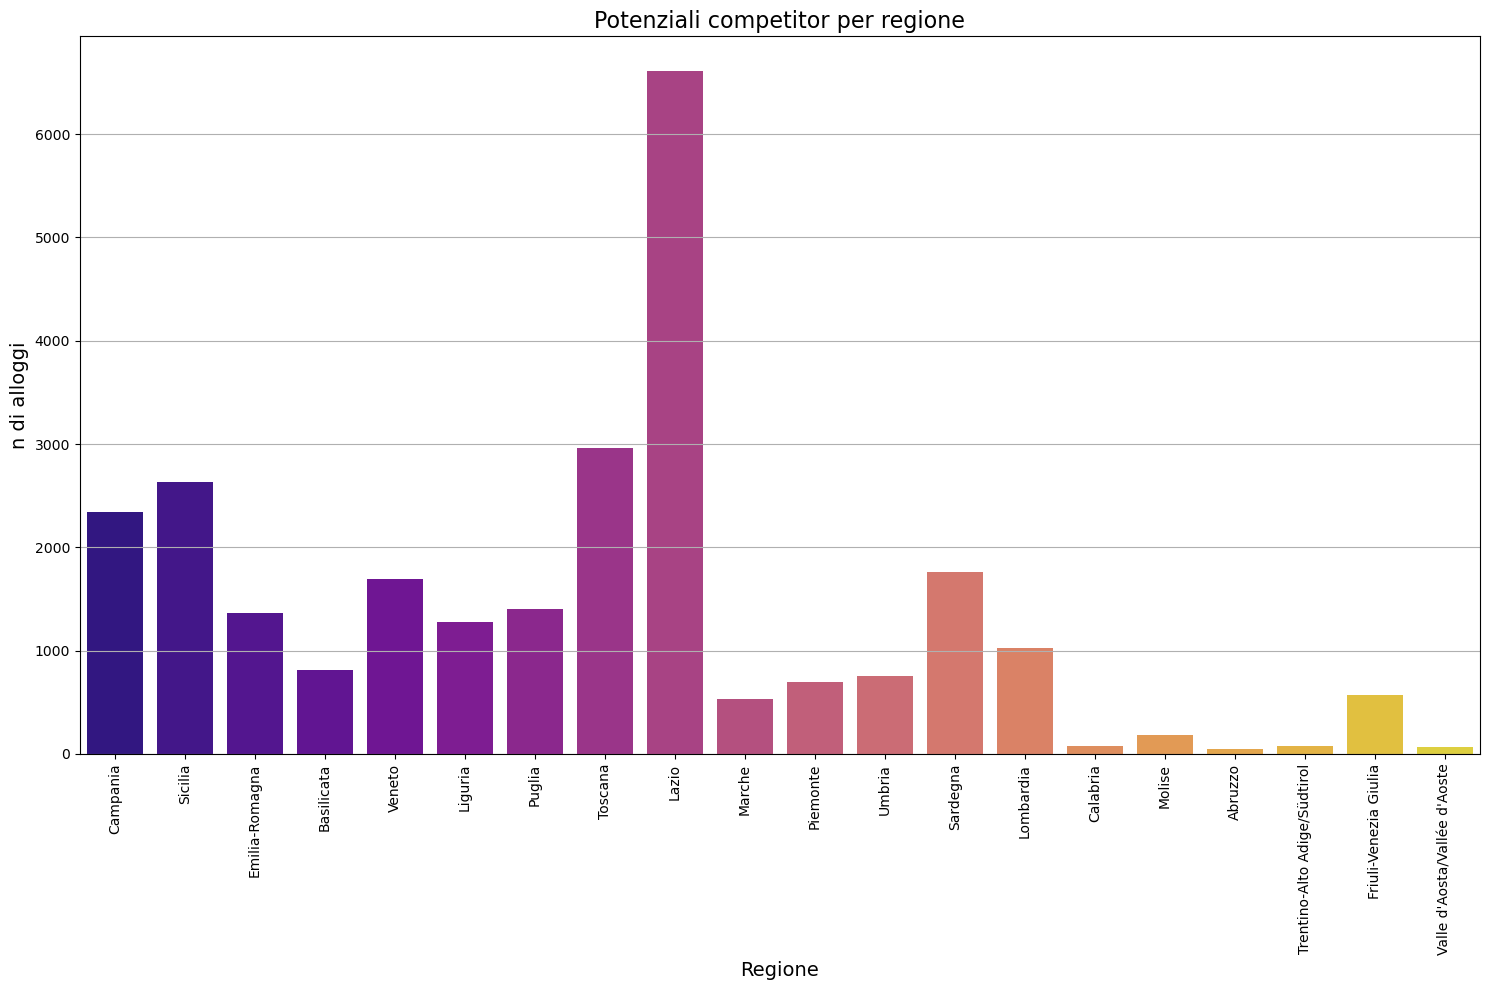

In [36]:
plt.figure(figsize=(15, 10))
sns.countplot(data = merged, x="regione", palette='plasma')
plt.xlabel('Regione', fontsize=14)
plt.ylabel('n di alloggi', fontsize=14)
plt.title('Potenziali competitor per regione', fontsize=16)
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.tight_layout()

Analizzeremo le opportunità di mercato degli affitti di guest house, concentrandoci sulle regioni. Valuteremo il numero di competitor presenti (rappresentato dal numero di alloggi per regione), prezzo medio degli alloggi e un indice che rappresenta il potenziale di penetrazione nel mercato. L'obiettivo è identificare le regioni più promettenti per investimenti futuri, individuando le aree con maggiore opportunità e quelle in cui è possibile posizionarsi con un'offerta competitiva.

In [37]:
n_alloggi_regione = merged.groupby('regione')['Guest House'].count()

In [38]:
prezzo_alloggi_regione = pd.merge(n_alloggi_regione, media_prezzo_regione, on = "regione", how="inner")

In [39]:
def calcola_opportunita(row):
    return row['prezzo_medio'] / row['Guest House']

prezzo_alloggi_regione['opportunità_di_mercato'] = prezzo_alloggi_regione.apply(calcola_opportunita, axis=1)

In [40]:
tabella_pivot_r_alloggi = prezzo_alloggi_regione.pivot_table(index='regione',
                                         values=['Guest House', 'prezzo_medio', 'opportunità_di_mercato']).sort_values(by='opportunità_di_mercato', 
                                                                                                                       ascending = False).reset_index().head(3)
tabella_pivot_r_alloggi

,regione,Guest House,opportunità_di_mercato,prezzo_medio
0,Calabria,79.0,1.963948,155.151899
1,Valle d'Aosta/Vallée d'Aoste,67.0,1.301626,87.208955
2,Abruzzo,52.0,1.083210,56.326923


Considerando il numero di guest house disponibili, le opportunità di mercato e il prezzo medio per regione, emergono indicazioni sulle aree dove è possibile penetrare con successo nel mercato. L'analisi è stata condotta utilizzando indicatori chiave come la densità competitiva (che è unguale al numero di alloggi sulla regione), il rapporto tra opportunità di mercato e prezzo medio.  

Regioni con maggiori opportunità sono:  

1. **Calabria**  

La Calabria presenta la maggiore opportunità di mercato tra le regioni analizzate. Con un numero moderato di competitor e un prezzo medio relativamente alto, ci sono spazi significativi per posizionarsi con offerte competitive e attrarre turisti in cerca di esperienze uniche.  

2. **Valle d'Aosta/Vallée d'Aoste:**  

Sebbene questa regione abbia un'opportunità di mercato inferiore rispetto alla Calabria, il numero ridotto di guest house e il prezzo medio accessibile rendono questa area un buon candidato per investimenti. La Valle d'Aosta, nota per il suo fascino naturale e culturale, potrebbe attrarre una clientela interessata a offerte specifiche legate a esperienze turistiche.

3. **Abruzzo:**  

Anche se l'Abruzzo presenta l'opportunità di mercato più bassa tra le tre regioni, il prezzo medio è significativamente inferiore, il che potrebbe attrarre turisti in cerca di opzioni più economiche.

## 6. Dove si Trovano gli Alloggi Meglio Valutati: Analisi delle Valutazioni Medie per Regione  

___

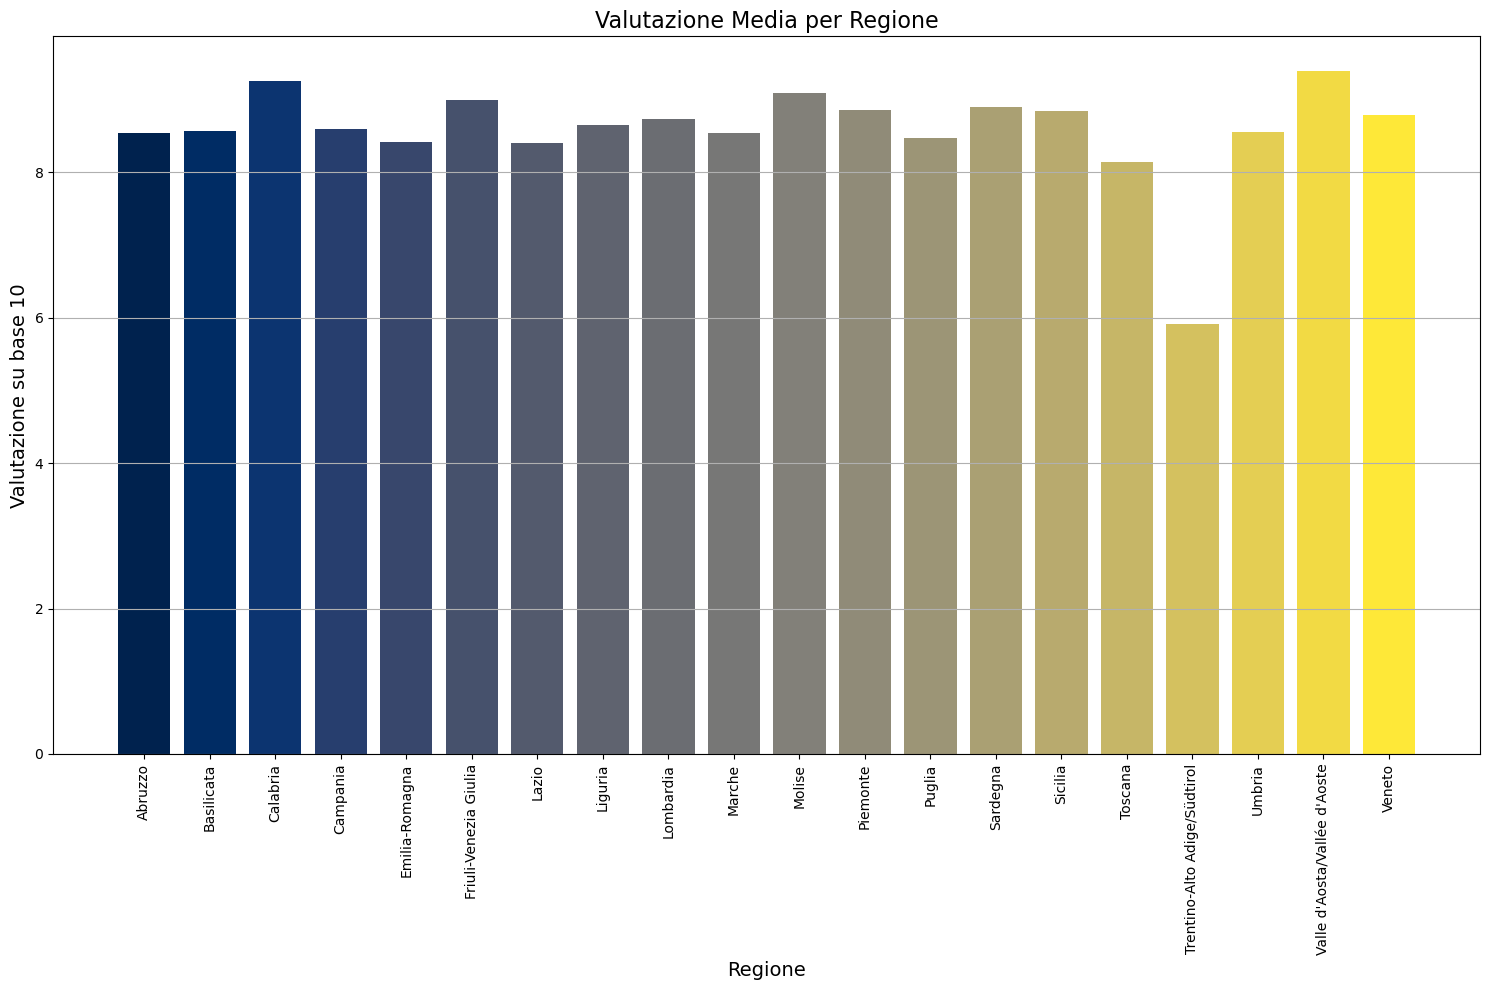

In [41]:
plt.figure(figsize=(15, 10))
colors = cm.cividis(np.linspace(0, 1, len(qualità_prezzo_regione)))
plt.bar(qualità_prezzo_regione['regione'], qualità_prezzo_regione['media_valutazione'], color=colors)
plt.xlabel('Regione', fontsize=14)
plt.ylabel('Valutazione su base 10', fontsize=14)
plt.title('Valutazione Media per Regione', fontsize=16)
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.tight_layout()

Dai dati analizzati emerge che le regioni italiane con le migliori valutazioni medie degli alloggi includono **Valle d'Aosta** (9.40), **Calabria** (9.25) e **Molise** (9.09). Queste regioni si distinguono per un alto grado di soddisfazione tra gli ospiti, riflettendo la qualità dell'ospitalità offerta.

Regioni come **Friuli-Venezia Giulia** (8.99), **Sardegna** (8.90) e **Piemonte** (8.86) si posizionano bene, con valutazioni sopra l'8.5, dimostrando una buona performance nel settore dell'accoglienza turistica.

Le regioni con valutazioni più basse includono il **Trentino-Alto Adige** (5.91), significativamente al di sotto della media, e la **Toscana** (8.14), nonostante la sua fama come destinazione turistica di rilievo

In [42]:
zona_valutazione = merged[['posizione', 'regione', 'luogo', 'valutazione']]

zona_valutazione_med = zona_valutazione.groupby(['regione', 'luogo'])['valutazione'].mean().sort_values(ascending = False).reset_index().head(5)

print(f"MIGLIORI GUEST HOUSE PER VALUTAZIONI RICEVUTE: \n{zona_valutazione_med}")

MIGLIORI GUEST HOUSE PER VALUTAZIONI RICEVUTE: 
     regione                luogo  valutazione
0   Piemonte               Locana     9.900000
1     Puglia              Pulsano     9.900000
2    Liguria                Cervo     9.800000
3     Puglia  Cassano delle murge     9.733333
4  Lombardia             Olginate     9.700000


Gli alloggi meglio valutati si trovano principalmente nelle regioni **Piemonte**, **Puglia**, **Liguria** e **Lombardia**, con una chiara distribuzione geografica che evidenzia la presenza di località eccellenti sia nel nord che nel sud Italia. Questa diversificazione riflette la qualità dell’offerta turistica in diverse aree del paese, anche in luoghi meno conosciuti rispetto alle destinazioni turistiche tradizionali.

## 7. Database Prezzo delle Case in Italia 
___ 

Carico il nuovo database

In [43]:
df_prezzo=pd.read_csv(r"sale_raw.csv")

In [44]:
print(f"INDICE COLONNE: \n{df_prezzo.columns}")

INDICE COLONNE: 
Index(['Prezzo €', 'm2', 'Piano', 'Contratto', 'Locali', 'Totale piani edificio', 'Caratteristiche', 'Città', 'Regione', 'Tipologia', 'Classe immobile', 'Prezzo $'], dtype='object')


In [45]:
valiori_null = df_prezzo.isnull().sum()
print(f"COLONNE CON VALORI NULLI: \n{valiori_null[valiori_null > 0]}")

COLONNE CON VALORI NULLI: 
Piano                     582
Locali                     21
Totale piani edificio     993
Caratteristiche             2
Città                       6
Classe immobile          1916
dtype: int64


Preparo i dati per le analisi

In [46]:
df_prezzo['Prezzo $'] = df_prezzo['Prezzo $'].str.replace('$', '')
df_prezzo['Prezzo $'] = df_prezzo['Prezzo $'].str.replace('.', '')
df_prezzo['Prezzo $'] = df_prezzo['Prezzo $'].str.replace(',', '.')
df_prezzo['Prezzo $'] = df_prezzo['Prezzo $'].str.replace(' ', '')
df_prezzo['Prezzo $'] = pd.to_numeric(df_prezzo['Prezzo $'])

In [47]:
df_prezzo['Prezzo €'] = df_prezzo['Prezzo €'].str.replace('€', '')
df_prezzo['Prezzo €'] = df_prezzo['Prezzo €'].str.replace('.', '')
df_prezzo['Prezzo €'] = df_prezzo['Prezzo €'].str.replace(',', '.')
df_prezzo['Prezzo €'] = df_prezzo['Prezzo €'].str.replace(' ', '')
df_prezzo['Prezzo €'] = pd.to_numeric(df_prezzo['Prezzo €'])

In [48]:
df_prezzo.shape

(23949, 12)

## 8. ROI
___

### 8.1 Prezzo medio del valore delle case in vendita per regione

In [49]:
prezzo_medio_case_regione = df_prezzo.groupby('Regione')['Prezzo $'].mean().round(2)

prezzo_medio_case_regione = prezzo_medio_case_regione.reset_index(name='prezzo_medio_case')

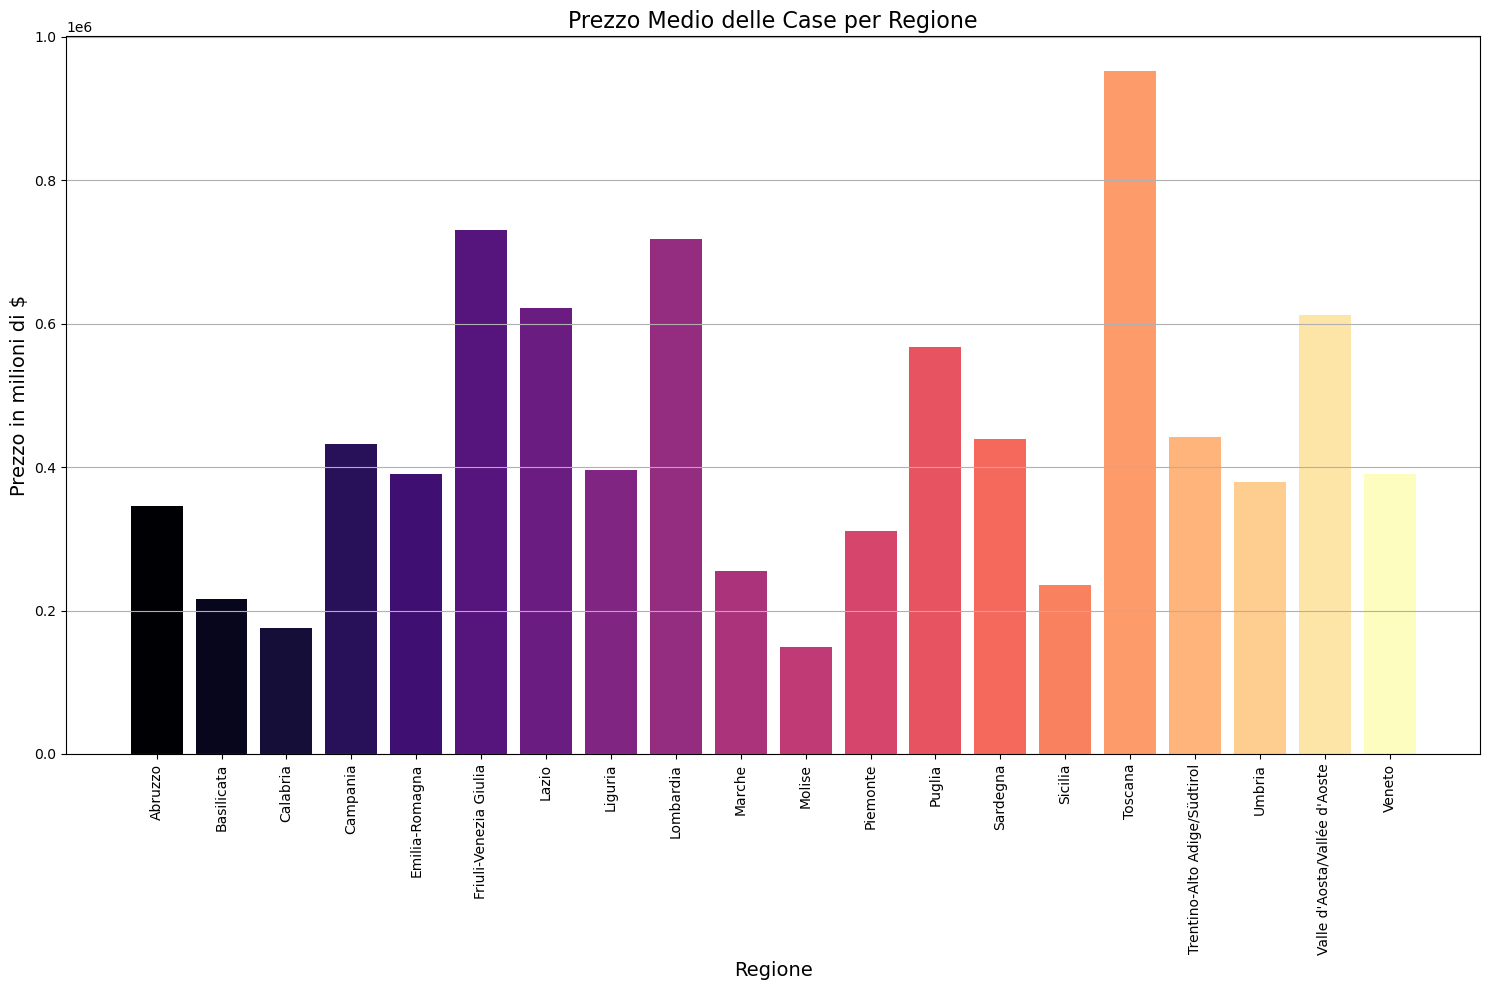

In [50]:
plt.figure(figsize=(15, 10))
colors = cm.magma(np.linspace(0, 1, len(prezzo_medio_case_regione)))
plt.bar( prezzo_medio_case_regione['Regione'], prezzo_medio_case_regione['prezzo_medio_case'], color=colors)
plt.xlabel('Regione', fontsize=14)
plt.ylabel('Prezzo in milioni di $', fontsize=14)
plt.title('Prezzo Medio delle Case per Regione', fontsize=16)
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.tight_layout()

Il grafico mostra una notevole variabilità nei prezzi medi delle abitazioni a seconda della regione, con differenze significative tra nord, centro e sud del Paese. Le regioni con prezzi medi più elevati tendono a concentrarsi nelle aree settentrionali e centrali d’Italia, mentre quelle con i prezzi più bassi si trovano principalmente nel sud.

- Regioni con i prezzi medi più alti:  

**Toscana:** con un prezzo medio di $953.176,26, è la regione più costosa. Questo può essere attribuito alla forte attrattività turistica, la bellezza paesaggistica e città storiche come Firenze e Siena, che rendono il mercato immobiliare particolarmente pregiato.  

**Friuli-Venezia Giulia:** con un prezzo medio di $730.215,00. La vicinanza all'Austria e la Slovenia, oltre a un'economia solida, può contribuire ai costi elevati delle abitazioni.  

**Lazio:** con un prezzo medio di $621.336,74. La presenza della capitale, Roma, una delle città più ambite e turistiche al mondo, influisce significativamente sul prezzo medio delle case.  

- Regioni con i prezzi medi più bassi:  

**Molise:** è la regione con il prezzo medio più basso, pari a $149.153,02. Il Molise è una delle regioni meno popolose e meno sviluppate economicamente, il che si riflette sui prezzi immobiliari.  

**Calabria:** con un prezzo medio di $175.897,06. Anche questa è una regione del sud Italia, caratterizzata da un mercato immobiliare più accessibile e meno dinamico rispetto ad altre regioni.  

**Basilicata:** con un prezzo medio di $216.214,68. Nonostante il fascino di città come Matera, il mercato immobiliare rimane contenuto, con prezzi relativamente bassi rispetto alla media nazionale.  

Le regioni con i prezzi più elevati tendono a essere quelle con un forte richiamo turistico e una maggiore densità abitativa, mentre le regioni meno costose si trovano generalmente in aree meno sviluppate dal punto di vista economico e con un mercato immobiliare più ridotto.

Ora creo un nuovo dateset aggiungendo la colonna <u>prezzo_medio_case</u> al dataset denominato <u>merged</u>

In [51]:
merged1 = pd.merge(merged, prezzo_medio_case_regione, left_on ='regione', right_on = 'Regione', how='inner')

In [52]:
merged1.drop(columns=['Regione'],inplace=True)

### 8.2 Ricavi Annui Regionali

Per questa analisi utilizzo come percentuale di occupazione media il dato fornito dall'[ISTAT](http://dati.istat.it/index.aspx?queryid=23190).

Costruisco una nuova colonna nel dataset con il dato sull'occupazione.

In [53]:
ricavi_occupazione = media_prezzo_regione

In [54]:
occupazione_media = {"Piemonte": 0.671, "Valle d'Aosta/Vallée d'Aoste": 0.718, "Lombardia": 0.693, "Trentino-Alto Adige/Südtirol": 0.723, 
                                                     "Veneto": 0.704, "Friuli-Venezia Giulia": 0.687, "Liguria": 0.674, "Emilia-Romagna": 0.708, "Toscana": 0.693, 
                                                     "Umbria": 0.665, "Marche": 0.674, "Lazio": 0.632, "Abruzzo": 0.613, "Molise": 0.569, "Campania": 0.444, "Puglia": 0.507, 
                                                     "Basilicata": 0.549, "Calabria": 0.446, "Sicilia": 0.449, "Sardegna": 0.561}

ricavi_occupazione['occupazione_media_regionale'] = ricavi_occupazione['regione'].map(occupazione_media)

Per il calcolo dei ricavi annui uso l'anno commerciale composto da 360 giorni

In [55]:

def calcola_ricavi_regionale(row):
    return row["prezzo_medio"] * (360 * row["occupazione_media_regionale"])

ricavi_occupazione['ricavi_occupazione_regionale'] = ricavi_occupazione.apply(calcola_ricavi_regionale, axis=1)

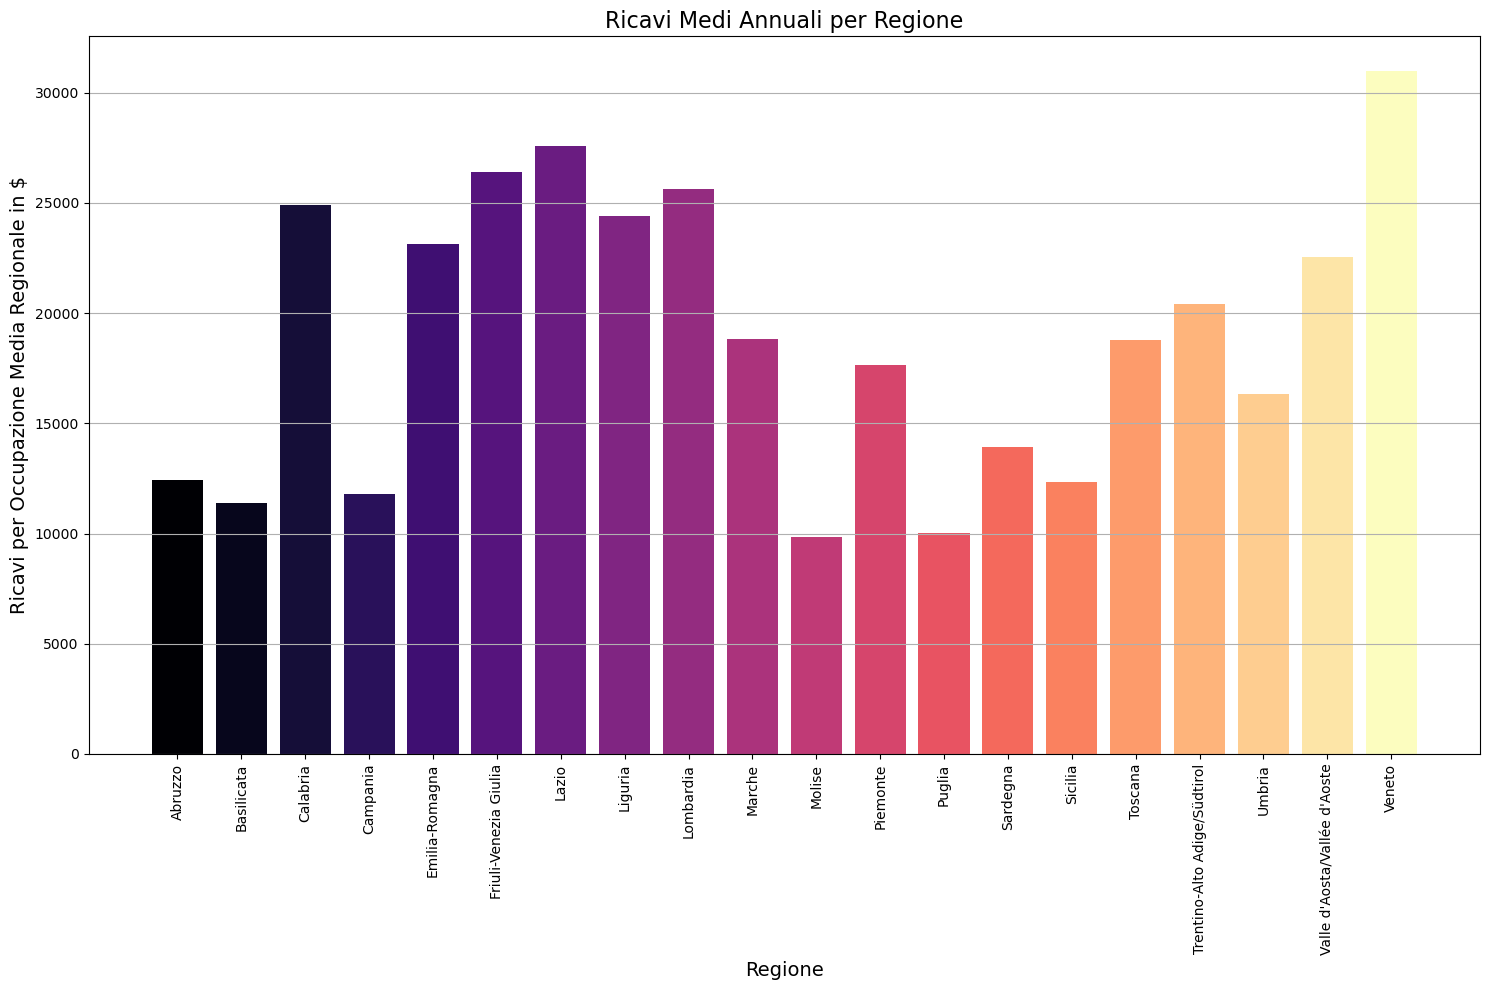

In [56]:
plt.figure(figsize=(15, 10))
colors = cm.magma(np.linspace(0, 1, len(ricavi_occupazione)))
plt.bar( ricavi_occupazione['regione'], ricavi_occupazione['ricavi_occupazione_regionale'], color=colors)
plt.xlabel('Regione', fontsize=14)
plt.ylabel('Ricavi per Occupazione Media Regionale in $', fontsize=14)
plt.title('Ricavi Medi Annuali per Regione', fontsize=16)
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.tight_layout()

 In questo grafico possiamo vedere ricavi medi delle case in Italia per regione, tenendo conto del rapporto tra prezzo medio delle case e il tasso di occupazione media regionale. I dati rivelano una notevole differenza nei ricavi generati dalle proprietà immobiliari tra le diverse regioni italiane.

**Le 3 regioni con i ricavi più alti:**  

- Veneto: con ricavi medi pari a 31.010,93 dollari, è la regione con il maggior rendimento delle case. Il Veneto ha un'economia forte e un elevato tasso di occupazione del 70,4%, il che rende il mercato immobiliare particolarmente redditizio.  

- Lazio: i ricavi medi ammontano a 27.604,59 dollari. La presenza di Roma e il peso economico e politico della regione contribuiscono a un mercato immobiliare molto attivo, con una buona occupazione del 63,2%.  

- Friuli-Venezia Giulia: i ricavi medi sono pari a 26.384,53 dollari. Anche qui l'occupazione è elevata (68,7%), e la regione beneficia di una buona performance economica e una qualità della vita elevata, fattori che favoriscono rendimenti immobiliari superiori.  

**Le 3 regioni con i ricavi più bassi:**  

- Molise: con ricavi medi di soli 9.837,83 dollari, è la regione con i ricavi più bassi. Il prezzo delle case è contenuto e il tasso di occupazione relativamente basso (56,9%), fattori che riducono il rendimento medio degli immobili.  

- Puglia: i ricavi medi ammontano a 10.043,68 dollari. Nonostante la popolarità turistica, la Puglia ha un tasso di occupazione inferiore (50,7%), che influisce negativamente sui ricavi immobiliari.  

- Basilicata: con ricavi medi pari a 11.395,37 dollari. Simile alla Puglia, ha un mercato immobiliare meno dinamico e un tasso di occupazione moderato (54,9%), che contribuisce a ricavi inferiori rispetto alla media nazionale.  

In [57]:
ROI_regionale = pd.merge(ricavi_occupazione, prezzo_medio_case_regione, left_on ='regione', right_on = 'Regione', how='inner')

ROI_regionale.drop(columns=['Regione'],inplace=True)

In [58]:
def calcola_ROI_regionale(row):
    return row["ricavi_occupazione_regionale"] / row["prezzo_medio_case"] * 100

ROI_regionale['ROI_occupazione_regionale'] = ROI_regionale.apply(calcola_ROI_regionale, axis=1)

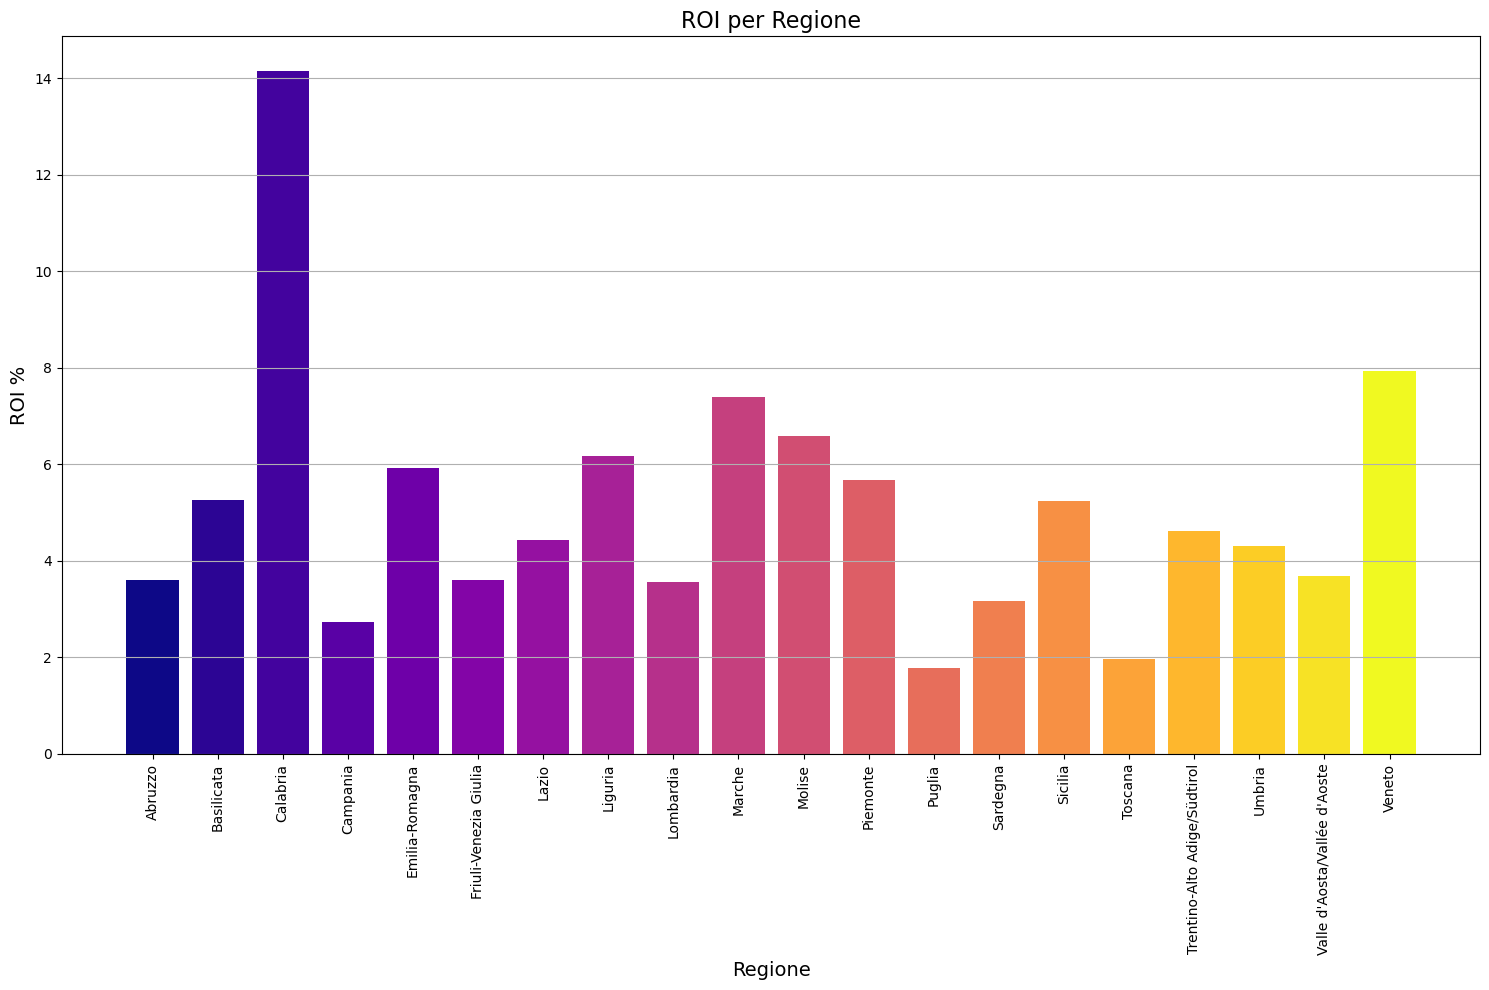

In [59]:
plt.figure(figsize=(15, 10))
colors = cm.plasma(np.linspace(0, 1, len(ROI_regionale)))
plt.bar(ROI_regionale['regione'], ROI_regionale['ROI_occupazione_regionale'], color=colors)
plt.xlabel('Regione', fontsize=14)
plt.ylabel('ROI %', fontsize=14)
plt.title('ROI per Regione', fontsize=16)
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.tight_layout()

Spiegare che il ROI calcolato è al netto dei costi che poi dovranno essere tolti dai ricavi

Il ROI (Ritorno sull'Investimento) lordo delle regioni italiane, calcolato sulla base dei ricavi derivanti dall'occupazione immobiliare regionale rispetto al prezzo medio delle case. Il grafico evidenzia variazioni significative nel ROI tra le diverse regioni, indicando la redditività degli investimenti immobiliari su scala regionale.

**Regioni con il ROI più alto:**  

1. Calabria – con un ROI del 14,16%, è la regione con il ritorno sull'investimento più elevato. Questo risultato è dovuto ai bassi prezzi delle case (175.897,06 dollari) e ai ricavi occupazionali relativamente elevati rispetto al costo degli immobili.  

2. Veneto – ha un ROI del 7,94%, uno dei più alti in Italia. La combinazione di un'elevata occupazione media di 70,4% e ricavi significativi (31.010,93 dollari) contribuisce a questo alto rendimento, nonostante i prezzi medi delle abitazioni non siano bassi.  

3. Marche – con un ROI del 7,39%, si distingue grazie a un prezzo medio delle case relativamente accessibile (254.701,88 dollari) e ricavi di occupazione consistenti rispetto all'investimento immobiliare.  

**Regioni con il ROI più basso:**

1. Puglia – con un ROI del 1,77%, è la regione con il ROI più basso. Nonostante i prezzi medi delle abitazioni siano relativamente alti (566.975,45 dollari), i ricavi legati all'occupazione immobiliare sono piuttosto contenuti, riducendo la redditività.  

2. Toscana – con un ROI del 1,97%, è una regione costosa (953.176,26 dollari per il prezzo medio delle case) e con ricavi che, pur essendo buoni, non compensano adeguatamente l’elevato costo degli immobili.  

3. Puglia – anche Lazio, con un ROI del 4,44%, presenta un ROI relativamente basso a causa del prezzo medio elevato delle case, che si aggira sui 621.336,74 dollari, pur avendo un buon tasso di occupazione e ricavi.  

Le regioni con il ROI più alto tendono ad avere prezzi medi delle case più bassi e ricavi immobiliari favorevoli, mentre le regioni con il ROI più basso sono caratterizzate da un elevato costo degli immobili, che riduce il rendimento complessivo dell'investimento.

## 9. Conclusioni
___

L'analisi del rapporto qualità-prezzo degli alloggi, insieme alla valutazione dei prezzi medi delle case e del rendimento immobiliare, offre un quadro chiaro delle opportunità e sfide nel settore turistico e immobiliare italiano. Le regioni con il miglior rapporto qualità-prezzo, come **Molise** e **Calabria**, si distinguono non solo per i prezzi più accessibili degli alloggi, ma anche per un interessante potenziale di rendimento sugli investimenti, grazie a un ROI elevato e ricavi immobiliari competitivi.

D'altro canto, le regioni con i prezzi immobiliari più elevati, come **Toscana**, **Friuli-Venezia Giulia** e **Lazio**, richiedono strategie di differenziazione per rimanere competitive nel mercato turistico e immobiliare, dove i costi elevati potrebbero ridurre la redditività. Nonostante il forte richiamo turistico e la stabilità economica di queste aree, il rendimento sugli investimenti è inferiore a causa dei prezzi elevati delle case, che limitano il ritorno economico.

Le regioni con prezzi più bassi, come **Molise**, **Calabria** e **Basilicata**, offrono margini di crescita significativi, sia per investimenti nel settore immobiliare che turistico, grazie a costi contenuti e un potenziale di ricavi interessante. In particolare, la *Calabria* si posiziona come un'area strategica per investimenti immobiliari, con un ROI molto elevato, dovuto a prezzi bassi e ricavi proporzionalmente alti.

In sintesi, l'analisi conferma che il mercato immobiliare e turistico italiano è caratterizzato da forti differenze geografiche. Le regioni meridionali offrono interessanti opportunità per investimenti a lungo termine, mentre le regioni centrali e settentrionali, seppur con prezzi più alti, possono garantire un flusso costante di domanda turistica.